### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import HTML
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# Covid epidemic simulator - illustrative Leeds example

In [5]:
from codit.disease import Covid
from codit.outbreak import Outbreak
from codit.outbreak_recorder import WardComponent
from codit.population.covid import PersonCovid
import codit.society as society
import codit.society.alternatives
import codit.config

from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras

(access to real data on Leeds)

In [6]:
import pandas as pd
from codit import share_dir
DATA_PATH = share_dir() / 'codit' / 'data'
TIME_SERIES_WARDS = DATA_PATH / 'city' / 'population' / 'Timeseries_Leeds_wards.csv'

### Baseline config of the simulation

We want to set up Leeds in lockdown 2021, so:

In [7]:
CITY_OBSERVE = 'Leeds'
POP_SIZE = city_paras[CITY_OBSERVE]['population']
LOCKDOWN_LEVEL = 0.66   # proportion of classrooms and workplaces to close down for lockdown
COVID_TYPE = 'B.1.1.7'

Here's some baseline config that is informing these simulations:

In [8]:
codit.config.print_baseline_config()

CROSS_IMMUNITY {'other': {'other'}, 'SARS-CoV-2': {'SARS-CoV-2', 'B.1.1.7'}, 'B.1.1.7': {'SARS-CoV-2', 'B.1.1.7'}}
DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DEFAULT_COVID SARS-CoV-2
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY {'SARS-CoV-2': 0.025, 'B.1.1.7': 0.039}
PROB_ISOLATE_IF_SYMPTOMS 0.75
PROB_ISOLATE_IF_TESTPOS 0.3
PROB_ISOLATE_IF_TRACED 0.3
PROB_NON_C19_SYMPTOMS_PER_DAY 0.01
PROB_SYMPTOMATIC 0.6
PROB_TEST_IF_REQUESTED 1
PROB_TRACING_GIVEN_CONTACT 0.6000000000000001
SIMULATOR_PERIODS_PER_DAY 1
TEST_DAYS_ELAPSED 1
VACCINATION_IMMUNITY {'AstraZeneca': {'SARS-CoV-2', 'B.1.1.7'}, 'Pfizer': {'SARS-CoV-2', 'B.1.1.7'}}
_PROPORTION_OF_INFECTED_WHO_GET_TESTED 0.44999999999999996
_TARGET_R0 1.4


We build a Leeds population:

In [9]:
pop = CityPopulation(POP_SIZE, society.Society(), person_type=PersonCovid, lockdown_level=LOCKDOWN_LEVEL)

2021-03-08 19:57:54,790 INFO:Building a set of 317255 households from which to build a population
2021-03-08 19:58:00,031 INFO:There are 316923 households generated for accommodation buildings
2021-03-08 19:58:04,208 INFO:317422 households of mean size 2.50
2021-03-08 19:58:04,901 INFO:Only putting children >12 years old into classrooms.
2021-03-08 19:58:04,902 INFO:There are 66.0% of classrooms closed due to lockdown, now 666 of classrooms are open
2021-03-08 19:58:05,081 INFO:666 classrooms of mean size 30.95
2021-03-08 19:58:05,361 INFO:122 care_homes of mean size 106.04
2021-03-08 19:58:06,373 INFO:Initially created 92152 workplaces
2021-03-08 19:58:06,417 INFO:After lockdown, there are 31331 workplaces open
2021-03-08 19:58:06,452 INFO:31331 workplaces of mean size 5.63
2021-03-08 19:58:06,530 INFO:Adding 349541 permanent contact groups
2021-03-08 19:58:06,674 INFO:Adding 39657 ephemeral contact pairs


Lets just check out the contact network a little more:

In [10]:
nets = [len(p.contacts) for p in pop.people]

print(f"""People typically come into physical contact with {np.median(nets):2.1f} people each day,
but on average {np.mean(nets):2.1f} people.
There are people seeing as many as {np.max(nets):2.0f} people each day""")

People typically come into physical contact with 3.0 people each day,
but on average 7.6 people.
There are people seeing as many as 149 people each day


### Finally ready to simulate:
We will place the population that we have created into various settings and societies in the upcoming simulations.
We begin by seeding the simulation with Covid, and allowing this to spread for 21 days of 'burn-in' before beginning to report simulation results.

In [11]:
BURNIN_DAYS = 21
DAYS_2021 = 66

In [12]:
PREVALENCE = 1/50
SCALE_SETTINGS = dict(n_days = BURNIN_DAYS + DAYS_2021, pop_size = POP_SIZE, 
                      seed_size = int(POP_SIZE*PREVALENCE), 
                      population=pop)
SCALE_SETTINGS

{'n_days': 87,
 'pop_size': 793139,
 'seed_size': 15862,
 'population': <codit.population.networks.city.CityPopulation at 0x1719b1df748>}

We simulate a PCR policy from 2020 of test, trace, and isolate, but with better testing capacity. Contacts, however, are not tested themselves.

In [13]:
soc = society.alternatives.UKSociety(config=dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01))

We use the 'Kent' variant of Covid:

In [14]:
disease = Covid(name=COVID_TYPE)

Combine these elements into our model, ready for simulation:

In [15]:
o = Outbreak(soc, disease, **SCALE_SETTINGS)

2021-03-08 19:58:15,527 WARNING:Using a pre-existing population - does it have the right network structure?


We set up some additional reporting at the ward level:

In [16]:
o.recorder.add_component(WardComponent(o))

We can use the cell below to pre-vaccinate some of the popl

In [17]:
# for p in o_UK_sim.pop.people:
#     if p.age > 70:
#         p.vaccinate_with('AstraZeneca')

#### OK, now lets run a simulation:

In [18]:
o.simulate()

2021-03-08 19:59:07,859 INFO:Day 1, prop infected is 0.02, prop infectious is 0.0143
2021-03-08 20:01:54,422 INFO:Day 51, prop infected is 0.10, prop infectious is 0.0043
2021-03-08 20:03:29,135 INFO:Day 87, prop infected is 0.11, prop infectious is 0.0009


2021-03-08 20:03:30,324 INFO: Realized R0 of early infections is 0.85
2021-03-08 20:03:30,325 INFO: 10.8 percent of the proportion was infected during the epidemic


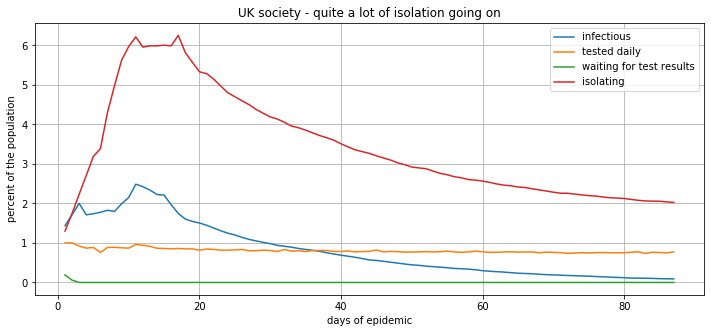

In [19]:
o.recorder.plot(title='UK society - quite a lot of isolation going on')

In [20]:
# visualizer = o.recorder.components[1]
# HTML(visualizer.outbreak_visualise(IS_HTML5))

In [21]:
ward_results = o.recorder.components[-1]

In [22]:
# for w in ward_results.wards:
#     print(len(ward_results.people_of[w]), w.name)

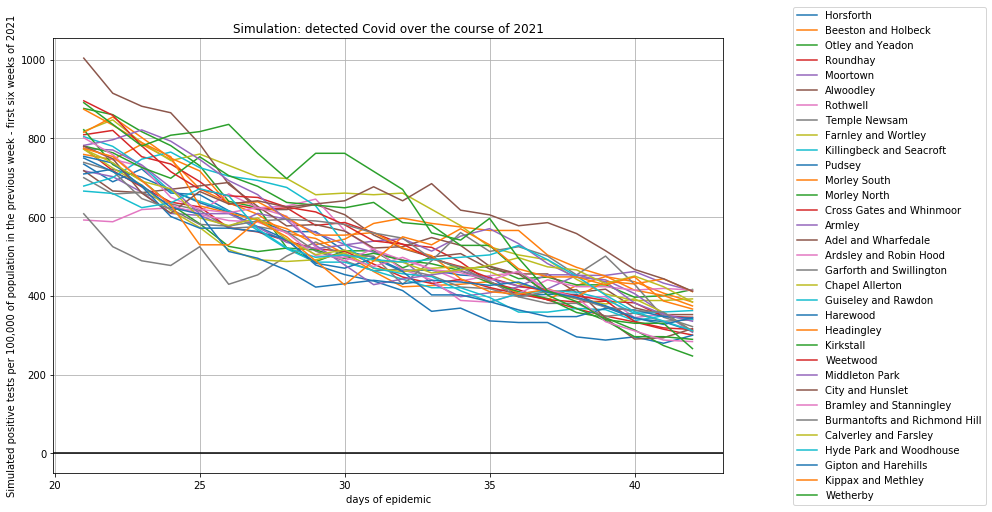

In [33]:
SIX_WEEKS = 6 * 7
df = ward_results.dataframe(ward_results.positive_tests)[BURNIN_DAYS:][:SIX_WEEKS] 
ax = (df * 100000).plot(grid=True, figsize=(12,8), title="Simulation: detected Covid over the course of 2021")
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
ax.set_ylabel("Simulated positive tests per 100,000 of population in the previous week - first six weeks of 2021")
_ = ax.axhline(0, color='k')

How does this stack up against the real ward-level data:

In [27]:
df_wards = pd.read_csv(TIME_SERIES_WARDS,index_col=0)

df_wards.drop(columns = [c for c in df_wards.columns if '2020' in c], inplace=True)
df_wards.drop(columns = df_wards.columns[-1:], inplace=True)  # here we remove the final datapoint which is < 1 week
df_wards.columns=[c[-10:] for c in df_wards.columns]

order = np.argsort(df_wards.iloc[:,-1:].values, axis=None) # get the order of the last column
df_wards = df_wards.iloc[np.flip(order)]     # sort the dataframe in decending order

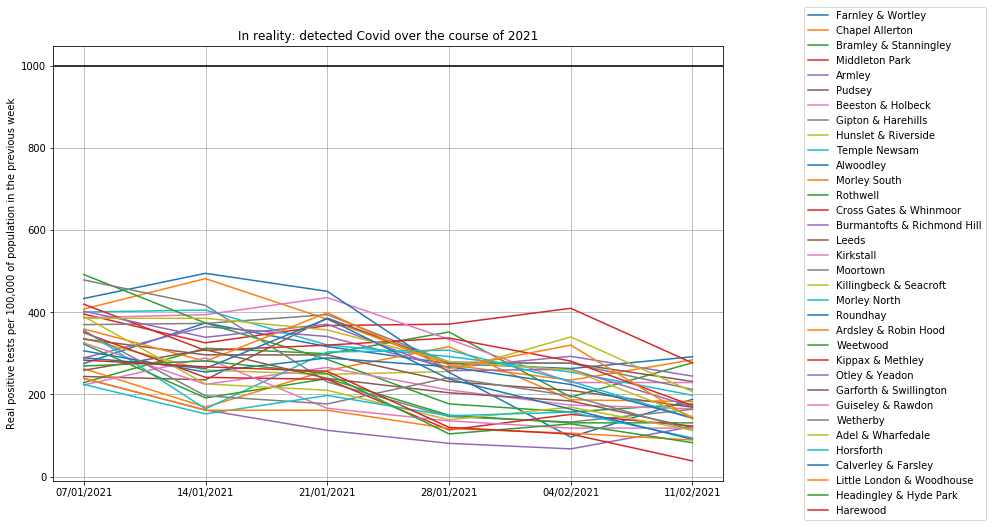

In [34]:
ax = df_wards.T.plot(title="In reality: detected Covid over the course of 2021", 
                              figsize=(12,8), grid=True)
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
ax.set_ylabel("Real positive tests per 100,000 of population in the previous week")
_ = ax.axhline(1000, color='k')